# Global Daily SST Analysis: Identifying Marine Extremes with `MarEx-Detect`

**MarEx-Detect** transforms raw oceanographic time series into standardised extreme event boolean datasets through a four-stage processing pipeline optimised for **exascale climate data**.

---

## Processing Stages

### 1. Anomaly Computation
Choose between two methodological approaches for calculating **anomalies**:

**Shifting Baseline** *(scientifically rigorous)*  
- Computes anomalies relative to backward-looking rolling climatology using previous N years of data
- More accurate representation of baseline conditions but computationally expensive
- Shortens usable time series by window duration

**Detrended Baseline** *(computationally efficient)*  
- Removes trends and seasonal cycles using harmonic decomposition (mean + annual/semi-annual harmonics + polynomial trends)
- Efficient processing but may introduce statistical biases in certain metrics

### 2. Threshold Calculation
Define percentile thresholds for extreme event detection:

**Hobday Extreme** *(methodologically accurate)*  
- Calculates day-of-year specific thresholds using local temporal windows
- In line with Hobday et al. (2016) methodology for marine heatwave detection of a single time-series
- Memory-intensive but captures seasonal variability evolution

**Global Extreme** *(computationally optimised)*  
- Applies single*percentile threshold computed globally across all time points
- Fast computation but may not capture seasonality evolution

### 3. Extreme Value Identification
Deploy percentile-based detection algorithms:
- Exact percentiles for precision or PDF-based histogram approximation for efficiency
- Optimised for massive datasets using vectorised operations, `dask` distributed computation, and `flox` for efficient aggregation & memory management

### 4. Output Assembly & Optimisation
Prepare data for downstream tracking algorithms:
- Intelligent chunking optimises Dask array patterns for parallel processing
- Zarr serialisation enables efficient distributed I/O operations

---

## Performance Benchmark

### Shifting-Baseline & Hobday Extreme Definition
70-year global daily analysis at 0.25° resolution (~1.5M grid points):
- **Completion time**: ~8 minutes using 256 cores
- **Scalability**: Linear scaling to 1024+ cores demonstrated

### Seasonal-Detrended & Global Extreme Definition
70-year global daily analysis at 0.25° resolution (~1.5M grid points):
- **Completion time**: ~2 minutes using 64 cores
- **Scalability**: Linear scaling to 256+ cores demonstrated

In [1]:
import xarray as xr
import numpy as np
import dask
import intake
from getpass import getuser
from pathlib import Path

import marEx
import marEx.helper as hpc

In [2]:
# Lustre Scratch Directory
scratch_dir = Path('/scratch') / getuser()[0] / getuser()

In [3]:
# Import 40 years of Daily ICON data (ref. EERIE project)

cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20240618'
model = 'icon-esm-er'
gridspec = 'gr025'

dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]

## **New** (v3.0) Pre-Process with Shifting-Baseline & Hobday et al. (2016) Definition for Extremes

In [4]:
# Start Distributed Dask Cluster
client = hpc.start_distributed_cluster(n_workers=256, workers_per_node=32, runtime=29, 
                                       scratch_dir=scratch_dir / 'clients', account='bk1377')    # Specify temporary scratch directory for dask to use

Dask Scratch: '/scratch/b/b382615/clients/tmp76mu8w9d'
Memory per Worker: 8.00 GB
Hostname: l40423
Forward Port: l40423:8889
Dashboard Link: localhost:8889/status


In [8]:
# Load Data
sst = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth')

In [9]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(sst, 
                                method_anomaly = 'shifting_baseline', # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
                                method_extreme = 'hobday_extreme',    # Local day-of-year specific thresholds with windowing
                                threshold_percentile = 95,            # Use the 95th percentile as the extremes threshold
                                window_year_baseline = 15, 
                                smooth_days_baseline = 21,            # Defines the rolling climatology window (15 years) and smoothing window (21 days) for determining the anomalies
                                window_days_hobday = 11,              # Defines the window (11 days) of compiled samples collected for the extremes detection
                                dimensions = {'time':'time',
                                              'xdim':'lon',
                                              'ydim':'lat'},  # Define the dimensions of the data -- if 'ydim' exists, then MarEx-Detect knows this is a gridded dataset
                                dask_chunks = {'time': 25})   # Dask chunks for *output* data
extremes_ds

<xarray.Dataset> Size: 77GB
Dimensions:         (lat: 721, lon: 1440, time: 14610, dayofyear: 366)
Coordinates:
  * lat             (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 117kB 1991-01-01T23:59:59 ... 2030-...
  * dayofyear       (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
Data variables:
    dat_detrend     (time, lat, lon) float32 61GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 15GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    thresholds      (lat, lon, dayofyear) float32 2GB 0.0 0.0 ... 0.00255 0.0023
Attributes:
    method_anomaly:        shifting_baseline
    method_extreme:        hobday_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Rolling climatology using 15 years', 'Smoothed w...
    window_year_baseline:  15
    smooth_days_baseline:  21
    window_days_hobday:    11

In [10]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / 'mhws' / 'extremes_binary_gridded_shifting.zarr'
extremes_ds.to_zarr(file_name, mode='w')

## Pre-Process with Seasonally-Detrended (Harmonic) Baseline & Global-in-Time Threshold Value

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(n_workers=64, threads_per_worker=1,
                                 scratch_dir = scratch_dir / 'clients')  # Specify temporary scratch directory for dask to use

In [11]:
# Choose optimal chunk size & load data
#   N.B.: For this method, it is crucial for dask (not only for performance, but also to make the problem tractable)
#         The operations in this package eventually require global-in-time operations,
#         therefore, a larger time chunksize is beneficial.

time_chunksize = 1000
sst = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':time_chunksize, 'lat':'auto', 'lon':'auto'})

In [12]:
# Ensure that the chunks are appropriately-sized
#  N.B.: The intermediate chunk size is the global-in-time memory footprint
#        It is good for each worker to have a few times more memory than this value

chunk_shape = sst.data.chunksize
intermediate_chunk_shape = (sst.sizes['time'],) + chunk_shape[1:]

print(f"Data Chunking (time, lat, lon): {chunk_shape}")
print(f"Initial Chunk Size: {np.prod(chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")
print(f"Intermediate Chunk Size: {np.prod(intermediate_chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")

Data Chunking (time, lat, lon): (1000, 129, 259)
Initial Chunk Size: 127.45 MB
Intermediate Chunk Size: 3584.48 MB


In [13]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(sst, 
                                method_anomaly = 'detrended_baseline', # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
                                method_extreme = 'global_extreme',    # Local day-of-year specific thresholds with windowing
                                threshold_percentile = 95,            # Use the 95th percentile as the extremes threshold
                                detrend_orders = [1, 2],      # Detrend the data using 1st & 2nd order polynomials (in addition to removing the mean & seasonal cycle/sub-cycle)
                                dimensions = {'time':'time',
                                              'xdim':'lon',
                                              'ydim':'lat'},  # Define the dimensions of the data -- if 'ydim' exists, then MarEx-Detect knows this is a gridded dataset
                                dask_chunks = {'time': 25})   # Dask chunks for *output* data
extremes_ds

<xarray.Dataset> Size: 146GB
Dimensions:         (lat: 721, lon: 1440, time: 28124)
Coordinates:
  * lat             (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 225kB 1991-01-01T23:59:59 ... 2067-...
Data variables:
    dat_detrend     (time, lat, lon) float32 117GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 29GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    thresholds      (lat, lon) float64 8MB nan nan nan nan ... 1.935 1.935 1.935
Attributes:
    method_anomaly:        detrended_baseline
    method_extreme:        global_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Removed polynomial trend orders=[1, 2] & seasona...
    detrend_orders:        [1, 2]
    force_zero_mean:       True
    std_normalise:         False
    exact_percentile:      False

In [14]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / 'mhws' / 'extremes_binary_gridded_detrend.zarr'
extremes_ds.to_zarr(file_name, mode='w')

# Compare Results of Pre-Processing Methods 

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask.array as da
import calendar
import matplotlib.dates as mdates

In [5]:
# Start Dask Cluster
client = hpc.start_local_cluster(n_workers=64, threads_per_worker=1,
                                 scratch_dir = scratch_dir / 'clients')  # Specify temporary scratch directory for dask to use

Dask Scratch: '/scratch/b/b382615/clients/tmp55qfjwe_'
Memory per Worker: 7.87 GB
Hostname: l40125
Forward Port: l40125:8787
Dashboard Link: localhost:8787/status


In [6]:
time_slice = slice('2006-01-01', '2030-12-31')
sst = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').sel(time=time_slice)
extremes_ds_shifting = xr.open_zarr(scratch_dir / 'mhws' / 'extremes_binary_gridded_shifting.zarr', chunks={}).sel(time=time_slice).chunk({'time':75, 'lat': 'auto','lon':'auto'})
extremes_ds_detrend = xr.open_zarr(scratch_dir / 'mhws' / 'extremes_binary_gridded_detrend.zarr', chunks={}).sel(time=time_slice).chunk({'time':75, 'lat': 'auto','lon':'auto'})

## Example of Timeseries and Thresholds
N.B.: Global-in-time threshold (`Detrend+Global`) creates anomalous extremes as systematic phenological shifts occur. e.g. If sharp seasonal shift occurs a bit earlier/later...

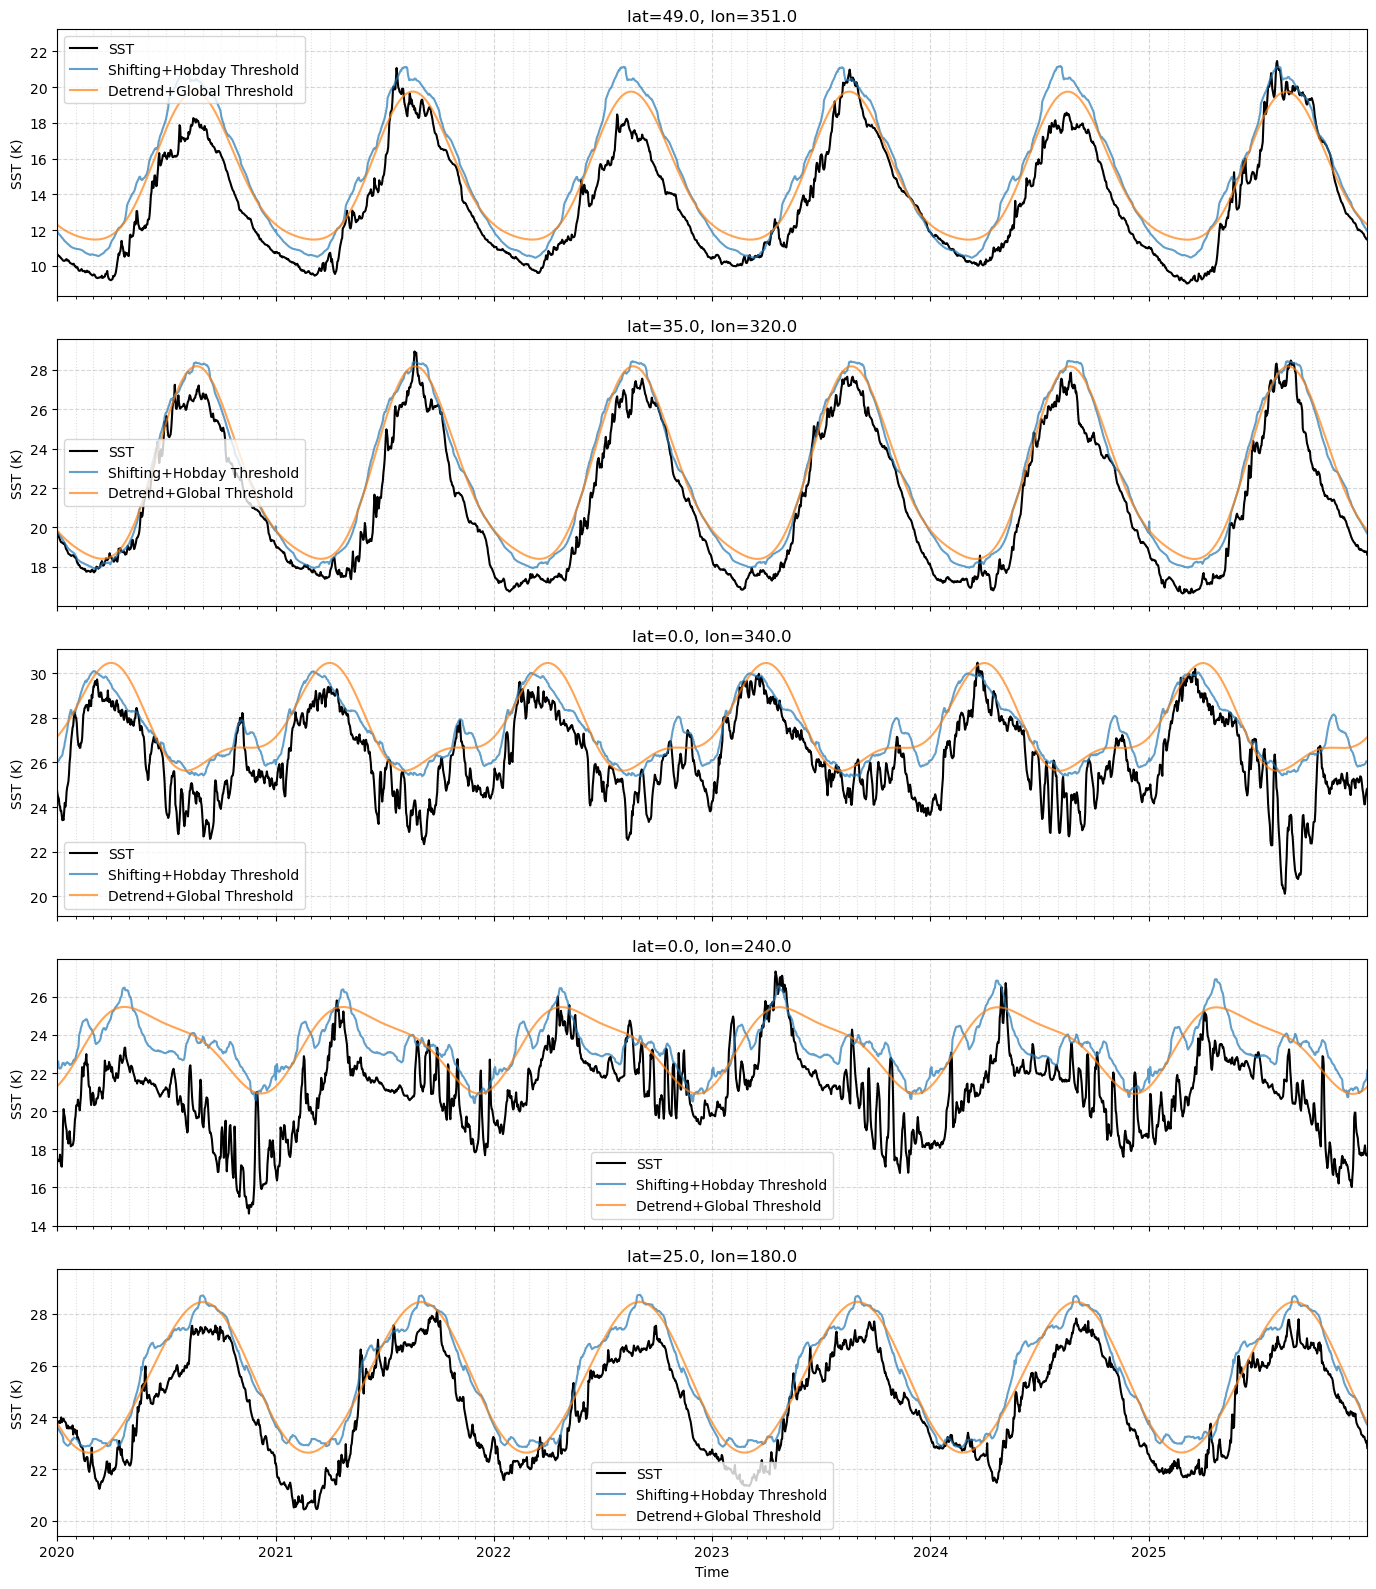

In [9]:
points = [
    (49., 351.),
    (35., 320.),
    (0.0, 340.),
    (0.0, 240.),
    (25.0, 180.)
]

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

for i, (lat_pt, lon_pt) in enumerate(points):
    sst_pt = sst.sel(lat=lat_pt, lon=lon_pt, method='nearest')
    shifting_thr_pt = (sst - extremes_ds_shifting.dat_detrend + 
                       extremes_ds_shifting.thresholds.sel(dayofyear=sst.time.dt.dayofyear)).sel(lat=lat_pt, lon=lon_pt, method='nearest')
    detrend_thr_pt = (sst - extremes_ds_detrend.dat_detrend + 
                      extremes_ds_detrend.thresholds).sel(lat=lat_pt, lon=lon_pt, method='nearest')

    axes[i].plot(sst_pt.time, sst_pt, color='black', label='SST')
    axes[i].plot(sst_pt.time, shifting_thr_pt, color='tab:blue', label='Shifting+Hobday Threshold', alpha=0.7)
    axes[i].plot(sst_pt.time, detrend_thr_pt, color='tab:orange', label='Detrend+Global Threshold', alpha=0.7)
    axes[i].set_xlim(np.datetime64('2020-01-01'), np.datetime64('2025-12-31'))
    axes[i].set_ylabel('SST (K)')
    axes[i].grid(True, which='major', linestyle='--', alpha=0.5)
    axes[i].grid(True, which='minor', linestyle=':', alpha=0.4, axis='x')
    axes[i].set_title(f'lat={lat_pt}, lon={lon_pt}')
    axes[i].legend()
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2,13)))
    axes[i].legend()
    

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

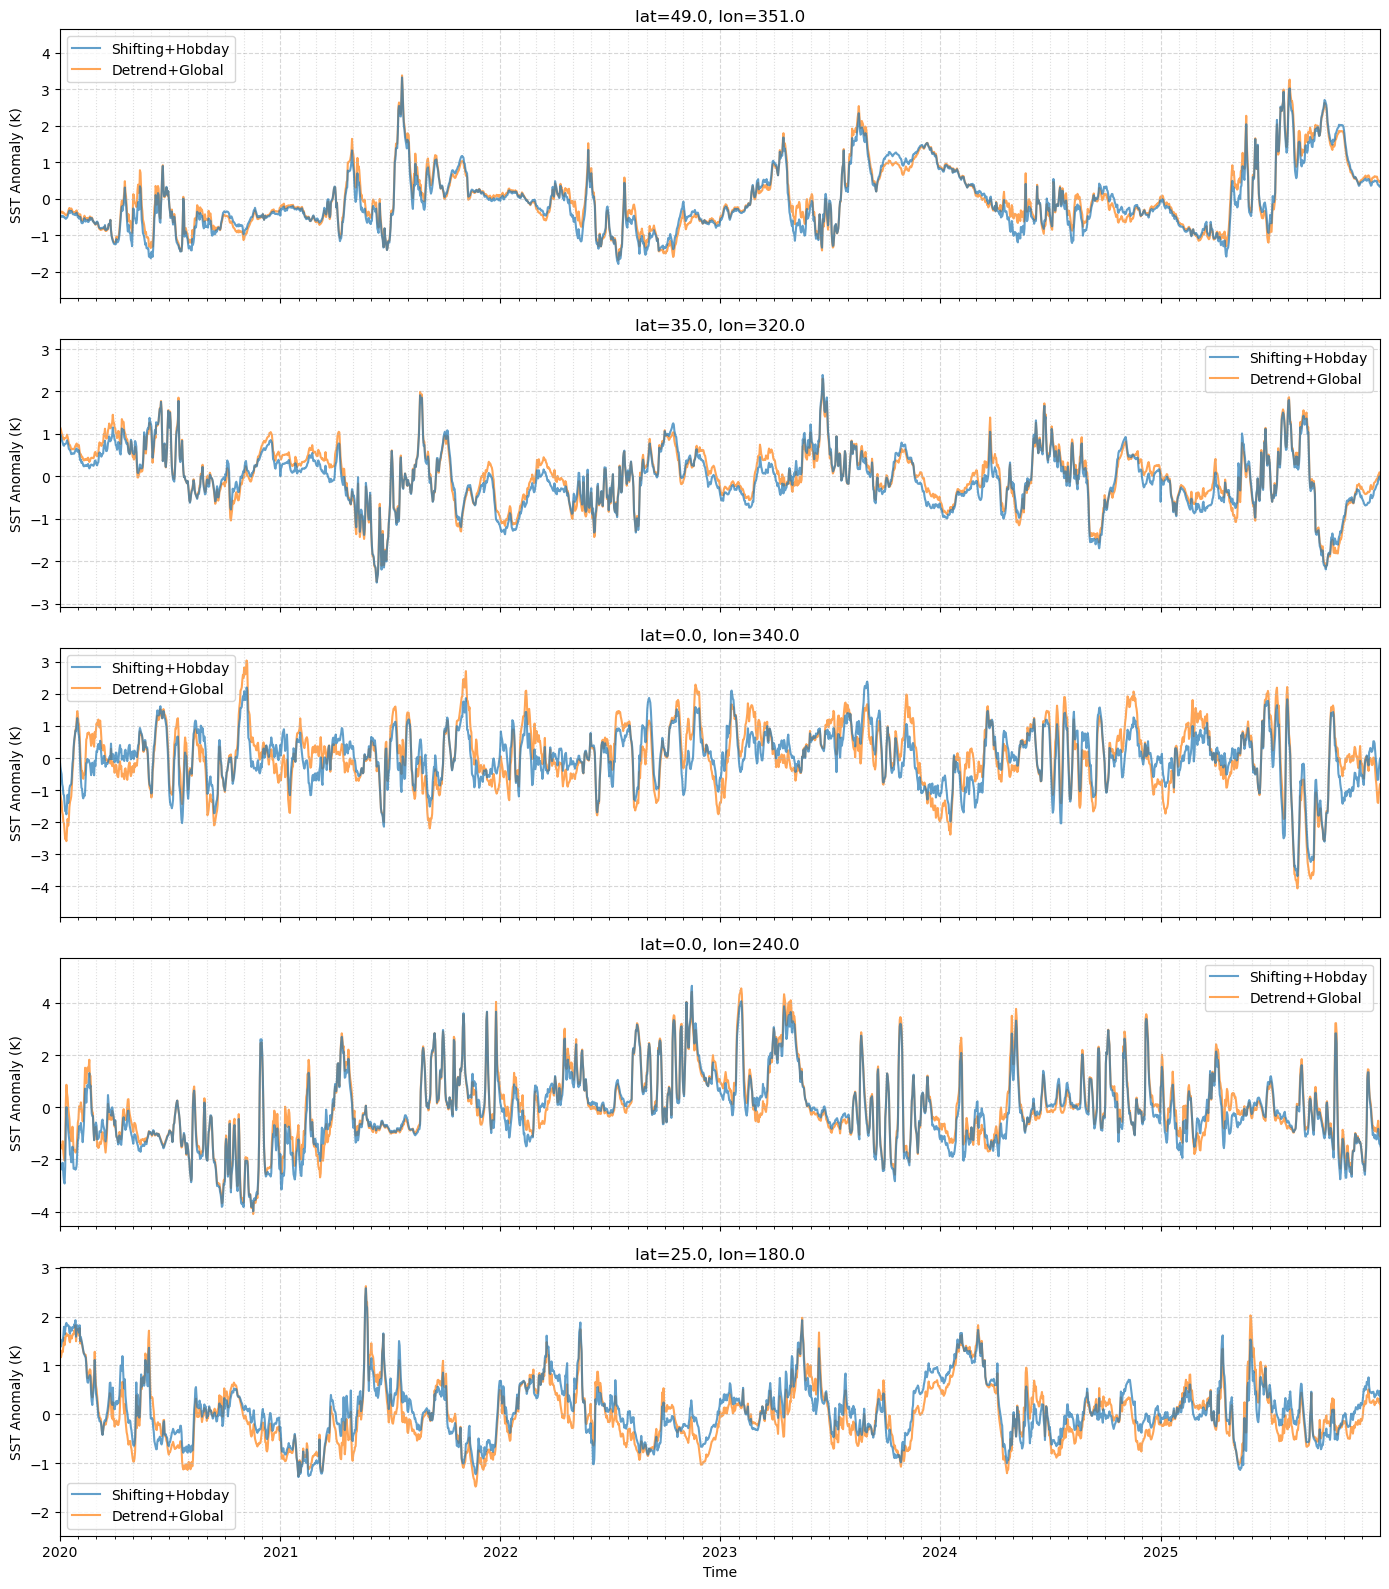

In [12]:
points = [
    (49., 351.),
    (35., 320.),
    (0.0, 340.),
    (0.0, 240.),
    (25.0, 180.)
]

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

for i, (lat_pt, lon_pt) in enumerate(points):
    sst_pt = sst.sel(lat=lat_pt, lon=lon_pt, method='nearest')
    shifting_anomaly_pt = extremes_ds_shifting.dat_detrend.sel(lat=lat_pt, lon=lon_pt, method='nearest')
    detrend_anomaly_pt = extremes_ds_detrend.dat_detrend.sel(lat=lat_pt, lon=lon_pt, method='nearest')

    axes[i].plot(shifting_anomaly_pt.time, shifting_anomaly_pt, color='tab:blue', label='Shifting+Hobday', alpha=0.7, zorder=2)
    axes[i].plot(detrend_anomaly_pt.time, detrend_anomaly_pt, color='tab:orange', label='Detrend+Global', alpha=0.7, zorder=1)
    axes[i].set_xlim(np.datetime64('2020-01-01'), np.datetime64('2025-12-31'))
    axes[i].set_ylabel('SST Anomaly (K)')
    axes[i].grid(True, which='major', linestyle='--', alpha=0.5)
    axes[i].grid(True, which='minor', linestyle=':', alpha=0.4, axis='x')
    axes[i].set_title(f'lat={lat_pt}, lon={lon_pt}')
    axes[i].legend()
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2,13)))

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

## Anomaly Distributions and Variance

/tmp/ipykernel_1837704/3889152571.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


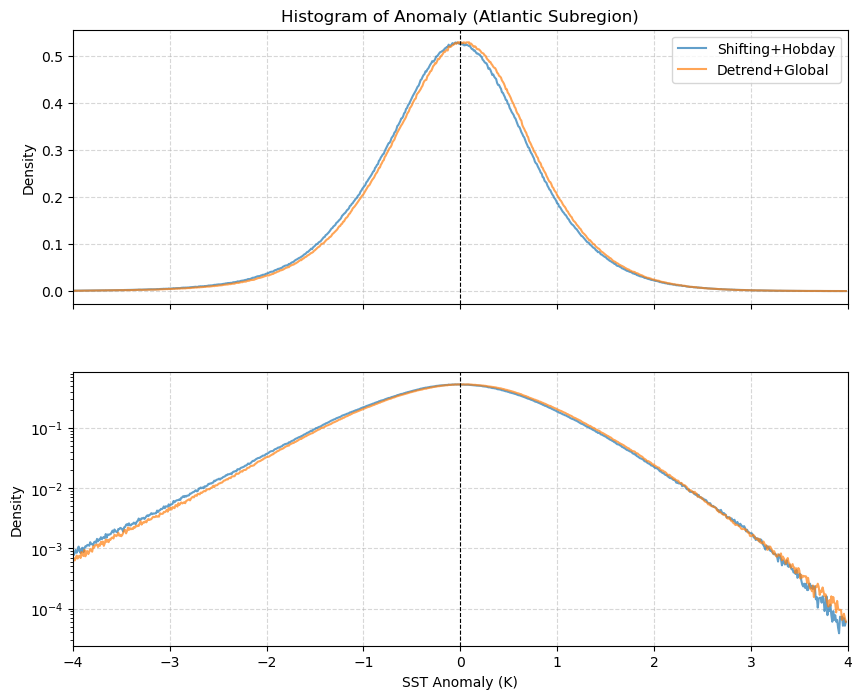

In [11]:
bins = np.arange(-4, 4, 0.01)
lat_slice = slice(35, 40)
lon_slice = slice(310,340)

dat_shifting = extremes_ds_shifting.dat_detrend.sel(lat=lat_slice, lon=lon_slice).data
dat_detrend = extremes_ds_detrend.dat_detrend.sel(lat=lat_slice, lon=lon_slice).data

hist_shifting, _ = da.histogram(dat_shifting, bins=bins, density=True)
hist_detrend, _ = da.histogram(dat_detrend, bins=bins, density=True)

hist_shifting_computed, hist_detrend_computed = dask.compute(hist_shifting, hist_detrend)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.25})

axes[0].plot(bins[:-1], hist_shifting_computed, label='Shifting+Hobday', alpha=0.7)
axes[0].plot(bins[:-1], hist_detrend_computed, label='Detrend+Global', alpha=0.7)
axes[0].set_ylabel('Density')
axes[0].set_title('Histogram of Anomaly (Atlantic Subregion)')
axes[0].set_xlim(-4, 4)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].legend()

axes[1].plot(bins[:-1], hist_shifting_computed, label='Shifting+Hobday', alpha=0.7)
axes[1].plot(bins[:-1], hist_detrend_computed, label='Detrend+Global', alpha=0.7)
axes[1].set_xlabel('SST Anomaly (K)')
axes[1].set_ylabel('Density')
axes[1].set_xlim(-4, 4)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_yscale('log')
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


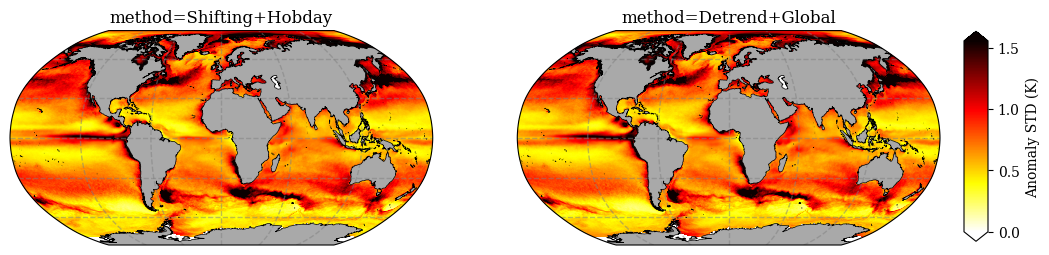

In [15]:
shifting_variance = extremes_ds_shifting.dat_detrend.std(dim='time')
detrend_variance = extremes_ds_detrend.dat_detrend.std(dim='time')

config = marEx.PlotConfig(var_units='Anomaly STD (K)', cmap='hot_r', cperc=[0,96], grid_labels=True)

combined_variance = xr.concat([shifting_variance, detrend_variance], dim='method')
combined_variance = combined_variance.assign_coords(method=['Shifting+Hobday', 'Detrend+Global'])

fig, axes = combined_variance.plotX.multi_plot(config, col='method', col_wrap=2)

## Global Extreme Event Frequency
N.B.: Hobday definition by construction ensures the frequency is near `1-percentile_threshold` or 5%. The pattern in the harmonic detrended data therefore arises entirely from the aharmonic shape of the seasonal cycle (cf. above timeseries).

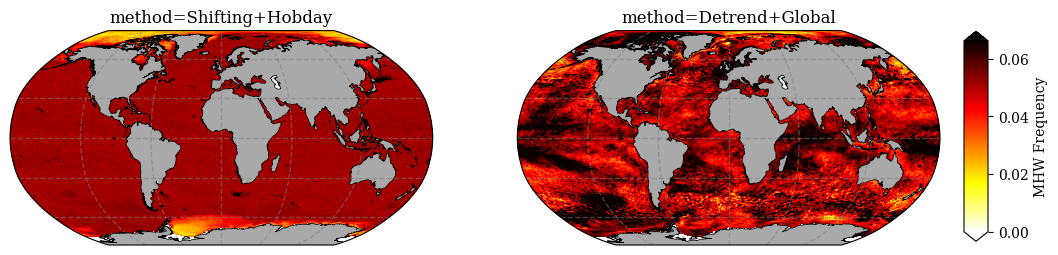

In [29]:
shifting_frequency = extremes_ds_shifting.extreme_events.mean(dim='time')
detrend_frequency = extremes_ds_detrend.extreme_events.mean(dim='time')

config = marEx.PlotConfig(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96], grid_labels=True)

combined_frequency = xr.concat([shifting_frequency, detrend_frequency], dim='method')
combined_frequency = combined_frequency.assign_coords(method=['Shifting+Hobday', 'Detrend+Global'])

fig, axes = combined_frequency.plotX.multi_plot(config, col='method', col_wrap=2)

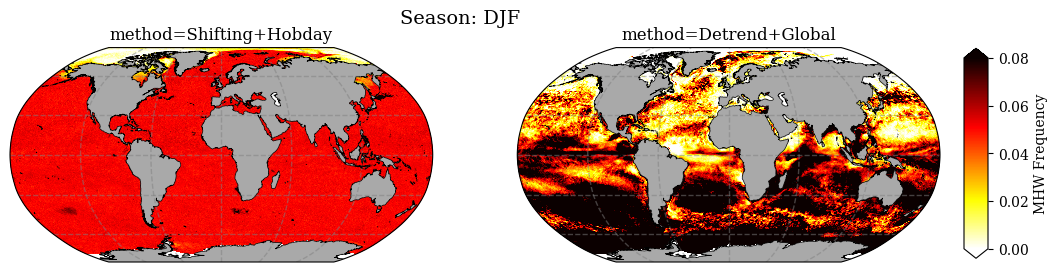

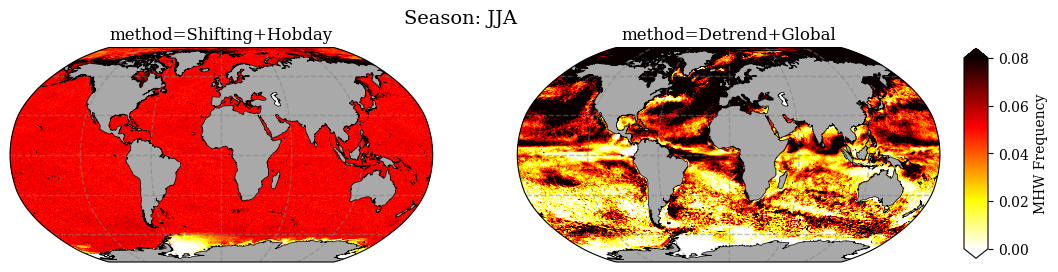

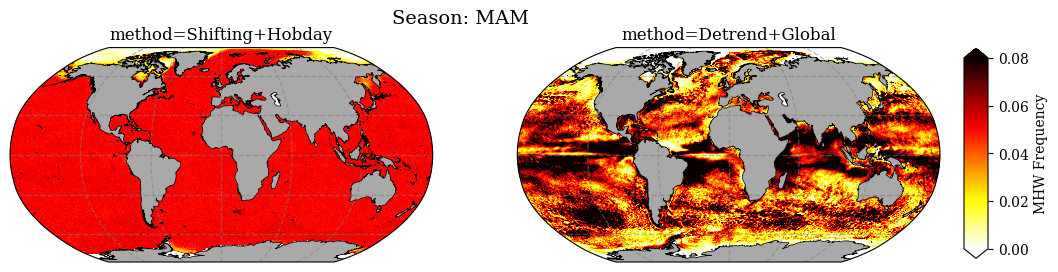

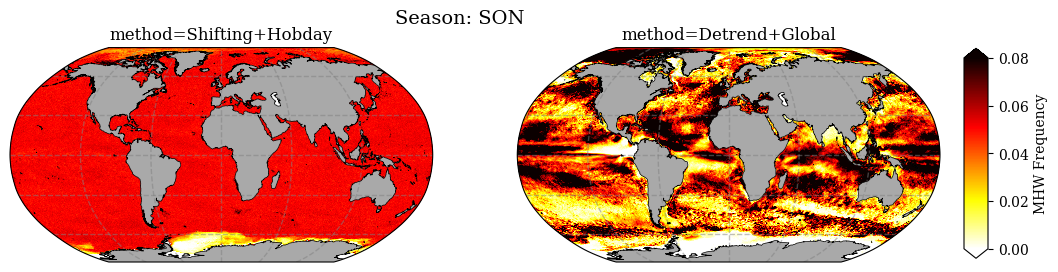

In [7]:
shifting_seasonal_frequency = extremes_ds_shifting.extreme_events.groupby('time.season').mean(dim='time').persist()
detrend_seasonal_frequency = extremes_ds_detrend.extreme_events.groupby('time.season').mean(dim='time').persist()

# Add method coordinate and concatenate
shifting_seasonal_frequency = shifting_seasonal_frequency.expand_dims({'method': ['Shifting+Hobday']})
detrend_seasonal_frequency = detrend_seasonal_frequency.expand_dims({'method': ['Detrend+Global']})
combined_seasonal_frequency = xr.concat([shifting_seasonal_frequency, detrend_seasonal_frequency], dim='method')

config = marEx.PlotConfig(var_units='MHW Frequency', cmap='hot_r', clim=[0,0.08], grid_labels=False, show_colorbar=True)

seasons = combined_seasonal_frequency['season'].values

for season in seasons:
    data = combined_seasonal_frequency.sel(season=season)
    fig, axes = data.plotX.multi_plot(
        config,
        col='method',
        col_wrap=2
    )
    fig.suptitle(f'Season: {season}', fontsize=14)
    plt.show()

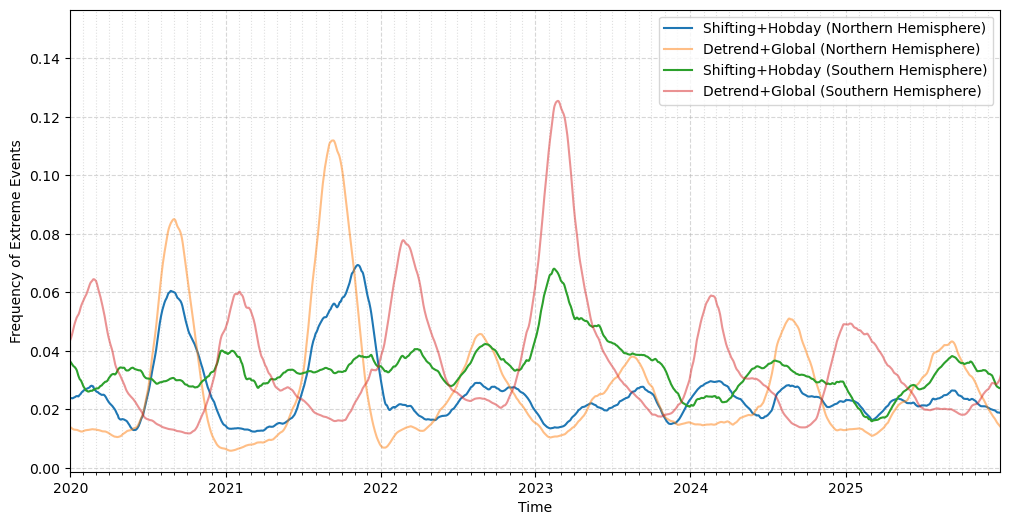

In [14]:
# Northern Hemisphere
monthly_shifting_north = extremes_ds_shifting.extreme_events.sel(lat=slice(0, 90)).mean(dim=['lat', 'lon']).rolling(time=60).mean()
monthly_detrend_north = extremes_ds_detrend.extreme_events.sel(lat=slice(0, 90)).mean(dim=['lat', 'lon']).rolling(time=60).mean()

# Southern Hemisphere
monthly_shifting_south = extremes_ds_shifting.extreme_events.sel(lat=slice(-90, 0)).mean(dim=['lat', 'lon']).rolling(time=60).mean()
monthly_detrend_south = extremes_ds_detrend.extreme_events.sel(lat=slice(-90, 0)).mean(dim=['lat', 'lon']).rolling(time=60).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_shifting_north.time, monthly_shifting_north, label='Shifting+Hobday (Northern Hemisphere)')
plt.plot(monthly_detrend_north.time, monthly_detrend_north, label='Detrend+Global (Northern Hemisphere)', alpha=0.5)
plt.plot(monthly_shifting_south.time, monthly_shifting_south, label='Shifting+Hobday (Southern Hemisphere)')
plt.plot(monthly_detrend_south.time, monthly_detrend_south, label='Detrend+Global (Southern Hemisphere)', alpha=0.5)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.grid(True, which='minor', linestyle=':', alpha=0.4, axis='x')
plt.xlabel('Time')
plt.ylabel('Frequency of Extreme Events')
plt.xlim(np.datetime64('2020-01-01'), np.datetime64('2025-12-31'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2,13)))
plt.legend()
plt.show()


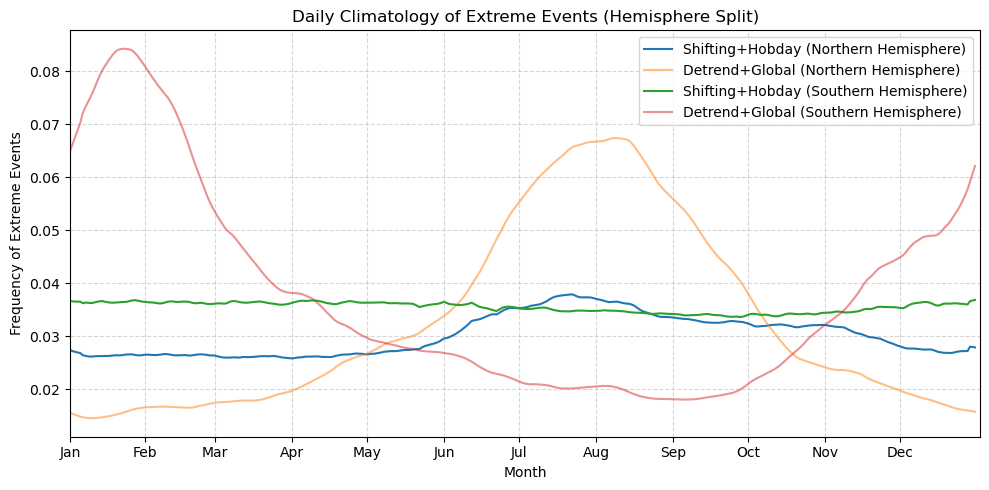

In [ ]:
# Daily climatology split by hemisphere
monthly_shifting_north = extremes_ds_shifting.extreme_events.sel(lat=slice(0, 90)).mean(dim=['lat', 'lon']).rolling(time=10,center=True).mean('time').groupby('time.dayofyear').mean(dim='time').isel(dayofyear=slice(0,-2))
monthly_shifting_south = extremes_ds_shifting.extreme_events.sel(lat=slice(-90, 0)).mean(dim=['lat', 'lon']).rolling(time=10,center=True).mean('time').groupby('time.dayofyear').mean(dim='time').isel(dayofyear=slice(0,-2))
monthly_detrend_north = extremes_ds_detrend.extreme_events.sel(lat=slice(0, 90)).mean(dim=['lat', 'lon']).rolling(time=10,center=True).mean('time').groupby('time.dayofyear').mean(dim='time').isel(dayofyear=slice(0,-2))
monthly_detrend_south = extremes_ds_detrend.extreme_events.sel(lat=slice(-90, 0)).mean(dim=['lat', 'lon']).rolling(time=10,center=True).mean('time').groupby('time.dayofyear').mean(dim='time').isel(dayofyear=slice(0,-2))

days = monthly_shifting_north.dayofyear.values
month_starts = [1] + list(np.cumsum([calendar.monthrange(2001, m)[1] for m in range(1,12)]))
month_labels = [calendar.month_abbr[m] for m in range(1,13)]

plt.figure(figsize=(10, 5))
plt.plot(days, monthly_shifting_north, label='Shifting+Hobday (Northern Hemisphere)')
plt.plot(days, monthly_detrend_north, label='Detrend+Global (Northern Hemisphere)', alpha=0.5)
plt.plot(days, monthly_shifting_south, label='Shifting+Hobday (Southern Hemisphere)')
plt.plot(days, monthly_detrend_south, label='Detrend+Global (Southern Hemisphere)', alpha=0.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Frequency of Extreme Events')
plt.title('Daily Climatology of Extreme Events (Hemisphere Split)')
plt.legend()

plt.xticks(month_starts, month_labels)
plt.xlim(1, 366)
plt.tight_layout()
plt.show()